In [1]:
import os
os.chdir(r'/Users/rmccrickerd/desktop/jdheston')

In [2]:
import numpy as np
import pandas as pd
from jdheston import jdheston as jdh
from jdheston import utils as uts
from jdheston import config as cfg
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.special import gamma
from scipy.optimize import minimize
# import mpl
# %matplotlib inline

In [3]:
nx = np.newaxis
cfg.config(scale=1.5,print_keys=False)

In [4]:
df = pd.read_excel('data/GBPUSD-20190619.xlsx')
df

,GBP,USD,Unnamed: 2,Bloomberg BGN,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,NaN,ATM,NaN,25D Call GBP,NaN,25D Put GBP,NaN,10D Call GBP,NaN,10D Put GBP,NaN
1,NaN,Mid,Spread,Mid,Spread,Mid,Spread,Mid,Spread,Mid,Spread
2,1W,5.57,1.95,5.771,2.471,5.774,2.47,6.24,4.644,6.26,4.644
3,1M,5.783,0.655,5.866,0.823,6.144,0.823,6.174,1.497,6.716,1.496
4,3M,6.83,0.75,6.729,0.942,7.528,0.942,7.013,1.714,8.479,1.711
5,6M,8.8,0.8,8.41,1.005,10.065,1.005,8.551,1.826,11.585,1.823
6,1Y,9.53,0.7,9.12,0.879,10.86,0.879,9.263,1.596,12.488,1.594
7,2Y,9.85,0.78,9.434,0.98,11.166,0.98,9.554,1.779,12.781,1.776


In [5]:
deltas = np.array([0.1,0.25,0.5,0.75,0.9])
expiries = np.array([1/52,1/12,3/12,6/12,1,2])
labels = ['1w','1m','3m','6m','1y','2y']

In [6]:
m,n = len(expiries),len(deltas)
mid_vols = np.zeros((m,n))
spreads = np.zeros((m,n))

In [7]:
mid_vols[:,0] = df.iloc[2:,9]
mid_vols[:,1] = df.iloc[2:,5]
mid_vols[:,2] = df.iloc[2:,1]
mid_vols[:,3] = df.iloc[2:,3]
mid_vols[:,4] = df.iloc[2:,7]

In [8]:
spreads[:,0] = df.iloc[2:,10]
spreads[:,1] = df.iloc[2:,6]
spreads[:,2] = df.iloc[2:,2]
spreads[:,3] = df.iloc[2:,4]
spreads[:,4] = df.iloc[2:,8]

In [9]:
plt.rcParams['figure.figsize'] = [4,12]
plt.rcParams['legend.loc'] = 'lower left'

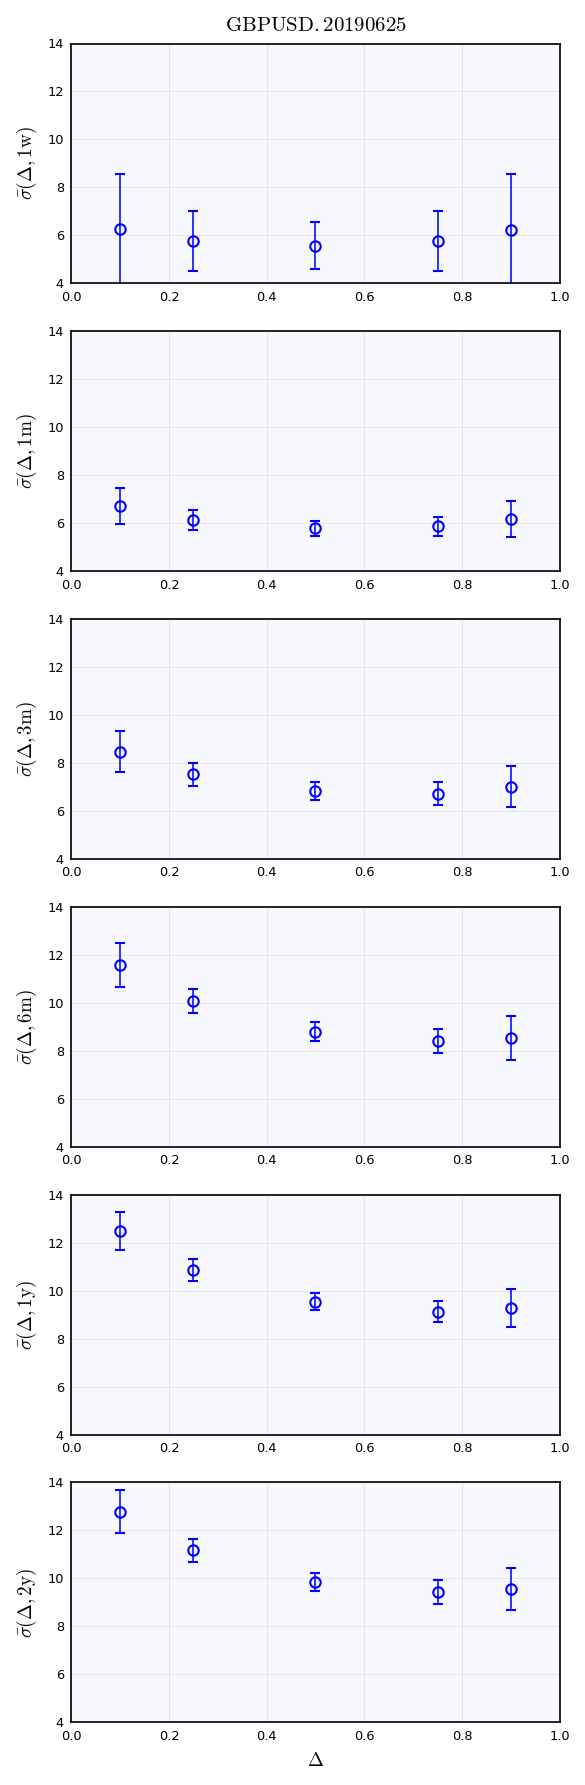

In [10]:
plot,axes = plt.subplots(m)
for i in range(m):
        axes[i].plot(deltas, mid_vols[i,:],'bo')
        
        for j in range(n):
            axes[i].plot([deltas[j],deltas[j]], [mid_vols[i,j] - spreads[i,j]/2,mid_vols[i,j] + spreads[i,j]/2],'b')
        axes[i].plot(deltas, mid_vols[i,:] + spreads[i,:]/2,'b_')
        axes[i].plot(deltas, mid_vols[i,:] - spreads[i,:]/2,'b_')
        axes[i].set_ylabel(r'$\bar{\sigma}(\Delta,\mathrm{%s})$'%labels[i])
        axes[i].set_ylim([4,14])
        axes[i].set_xlim([0,1])
axes[0].set_title(r'$\mathrm{GBPUSD.20190625}$')
axes[-1].set_xlabel(r'$\Delta$')
plt.tight_layout()

In [11]:
vols = mid_vols/100

In [12]:
vol_surface = jdh.vol_surface(expiries[:,nx], deltas[nx,:], vols)

In [13]:
vol_surface.fit_jheston()

C:\Users\rmccrickerd\desktop\jdheston\jdheston\jdheston.py:218: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p = 1 - 1/np.pi*np.exp(k/2)*quad(jheston_integrand,0,u,args=(t,k,Θ))[0]
C:\Users\rmccrickerd\desktop\jdheston\jdheston\jdheston.py:210: RuntimeWarning: invalid value encountered in cdouble_scalars
  return np.exp((1 - a - np.sqrt((1 - a)**2 + (σ*v)**2*u*(i + u)))/v**2*t)
C:\Users\rmccrickerd\desktop\jdheston\jdheston\jdheston.py:218: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error m

,sigma,rho,vee,rmse
0.019231,0.060010,-0.001463,0.121386,0.000039
0.083333,0.062138,-0.100589,0.239810,0.000141
0.250000,0.074452,-0.216672,0.460320,0.000172
0.500000,0.097081,-0.334427,0.677276,0.000351
1.000000,0.104896,-0.323412,0.945555,0.000337
2.000000,0.107867,-0.312097,1.291523,0.000321


In [14]:
T = expiries[:,nx]
average_vols = np.array(vol_surface.jheston['sigma'].copy())
forward_vols = average_vols.copy()
for i in np.arange(1,m):
    forward_vols[i] = np.sqrt((average_vols[i]**2*T[i,0] - average_vols[i-1]**2*T[i-1,0])/(T[i,0] - T[i-1,0]))

Put this in function

In [15]:
forward_vols

array([0.06000998, 0.06276207, 0.07990018, 0.11535298, 0.1121676 ,
       0.11075792])

In [16]:
jump_weight = 0.5
jump_sigma = jump_weight**0.5*forward_vols
diff_sigma = (1 - jump_weight)**0.5*forward_vols

In [17]:
times1   = np.array([0,1/52,1/12,3/12,6/12,1])
sigma1   = jump_sigma
rho1     = np.array([0])*np.ones_like(times1)
vee1     = np.array([1])*np.ones_like(times1)
epsilon1 = np.array([1])*np.ones_like(times1)

In [18]:
times2   = np.array([0,1/52,1/12,3/12,6/12,1])
sigma2   = diff_sigma
rho2     = np.array([0])*np.ones_like(times2)
vee2     = np.array([1])*np.ones_like(times2)
epsilon2 = np.array([1])*np.ones_like(times2)

In [19]:
params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T

In [20]:
# eps2 = 0.25

In [21]:
# manually select desired calibration vols
vol_surface.vols[1:-1,1:-1]

array([[0.06144, 0.05783, 0.05866],
       [0.07528, 0.0683 , 0.06729],
       [0.10065, 0.088  , 0.0841 ],
       [0.1086 , 0.0953 , 0.0912 ]])

In [34]:
T = vol_surface.expiries
k = vol_surface.logstrikes #[1:-1,1:-1]
vols = vol_surface.vols #[1:-1,1:-1]

In [35]:
def rmse(x):
    jump_weight, rho1, rho2, vee1, vee2, eps2 = x
    
    jump_sigma = jump_weight**0.5*forward_vols
    diff_sigma = (1 - jump_weight)**0.5*forward_vols
    
    sigma1   = jump_sigma
    rho1     = np.array([rho1])*np.ones_like(sigma1)
    vee1     = np.array([vee1])*np.ones_like(sigma1)
    
    sigma2   = diff_sigma
    rho2     = np.array([rho2])*np.ones_like(sigma2)
    vee2     = np.array([vee2])*np.ones_like(sigma2)
    epsilon2 = np.array([eps2])*np.ones_like(sigma2)
    
    params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
    params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T
    
    call_prices = jdh.jdh2f_pricer(T, k, [params1, params2])
    model_vols = jdh.surface(T, k, call_prices)
    
    rmse = np.sqrt(np.mean((model_vols - vols)**2))
    return 100*rmse

In [36]:
x0 = 0.5262624 , -0.81429643,  0.09210706,  2.82957019,  1.23453093, 0.05671884 # for epsilon = 1.0

In [37]:
results = minimize(rmse, x0,
                   method = 'L-BFGS-B',
                   # args = (expiry, logstrikes, vols),
                   bounds = ((0.01,0.99), (-1,1), (-1,1), (0,None), (0,None), (0,None)),
                   options = {'maxiter': 10}
              )
results

      fun: 0.1436781649176558
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0258594 ,  0.01297877,  0.00912985, -0.00314201,  0.00070714,
        0.00947259])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 91
      nit: 10
   status: 1
  success: False
        x: array([ 0.51817261, -0.82680433,  0.08338753,  2.83370506,  1.21692816,
        0.05745263])

In [38]:
jump_weight, rho1, rho2, vee1, vee2, eps2 = results.x

In [39]:
max_sigma = 0.135
T = vol_surface.expiries
Δ = np.linspace(5,95,19)[nx,:]/100
k = norm.ppf(Δ)*max_sigma*np.sqrt(T)

In [40]:
jump_sigma = jump_weight**0.5*forward_vols
diff_sigma = (1 - jump_weight)**0.5*forward_vols

sigma1   = jump_sigma
rho1     = np.array([rho1])*np.ones_like(sigma1)
vee1     = np.array([vee1])*np.ones_like(sigma1)

sigma2   = diff_sigma
rho2     = np.array([rho2])*np.ones_like(sigma2)
vee2     = np.array([vee2])*np.ones_like(sigma2)
epsilon2 = np.array([eps2])*np.ones_like(sigma2)

params1  = np.array([times1, sigma1, rho1, vee1, epsilon1]).T
params2  = np.array([times2, sigma2, rho2, vee2, epsilon2]).T

call_prices = jdh.jdh2f_pricer(T, k, [params1, params2])
implied_vols = jdh.surface(T, k, call_prices)
    
implied_vars = implied_vols*np.sqrt(T)
Δ = norm.cdf(k/implied_vars + 0.5*implied_vars)

In [46]:
plt.rcParams['figure.figsize'] = [4,12]
plt.rcParams['legend.loc'] = 'upper left'

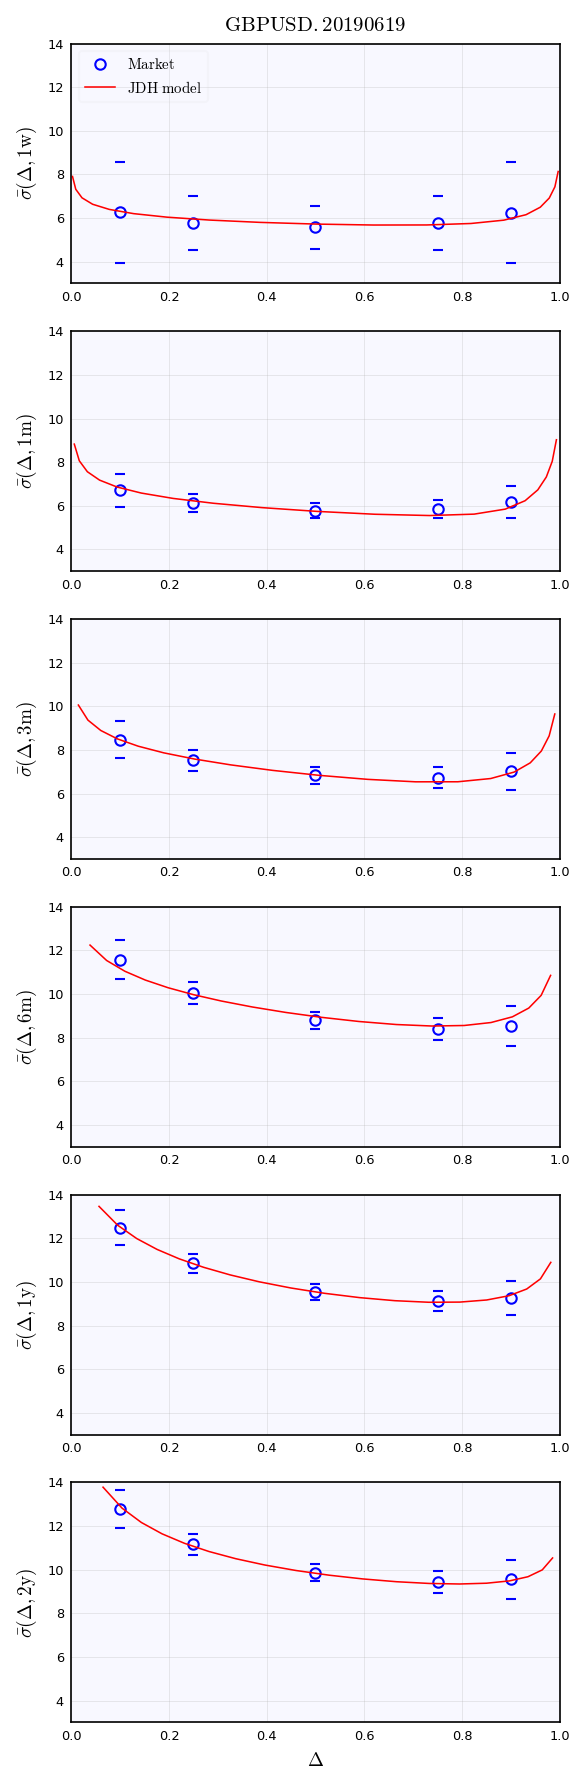

In [48]:
plot,axes = plt.subplots(m)
for i in range(len(T[:,0])):
    axes[i].plot(deltas, mid_vols[i,:],'bo')
    axes[i].plot(Δ[i,:],100*implied_vols[i,:])
    
    axes[i].plot(deltas, mid_vols[i,:] + spreads[i,:]/2,'b_')
    axes[i].plot(deltas, mid_vols[i,:] - spreads[i,:]/2,'b_')
    
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([3,14])
    axes[i].set_ylabel(r'$\bar{\sigma}(\Delta,\mathrm{%s})$'%labels[i])
axes[0].set_title(r'$\mathrm{GBPUSD.20190619}$')
axes[0].legend([r'$\mathrm{Market}$',r'$\mathrm{JDH\ model}$'])
axes[-1].set_xlabel(r'$\Delta$')
plt.tight_layout()
plt.savefig('plots/GBPUSD-20190619')

In [53]:
from cycler import cycler
plt.rcParams['figure.figsize'] = [4,4/1.618]
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['axes.prop_cycle'] = cycler(color=['r','coral','gold','g','b','indigo'])

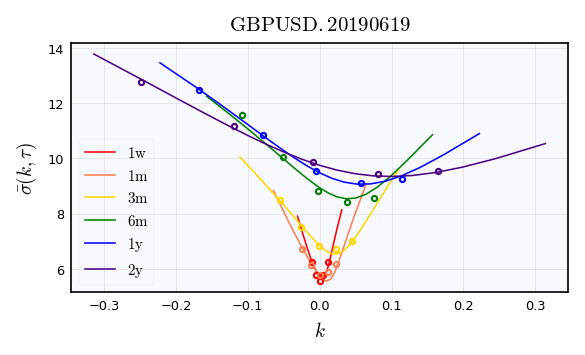

In [71]:
plot,axes = plt.subplots()
for i in range(len(T[:,0])):
    axes.plot(k[i,:],100*implied_vols[i,:])
for i in range(len(T[:,0])):
    axes.plot(vol_surface.logstrikes[i,:],100*vol_surface.vols[i,:],marker='.',linestyle='')
    
axes.legend([r'$\mathrm{1w}$',
             r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{1y}$',
             r'$\mathrm{2y}$'])
axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_title(r'$\mathrm{GBPUSD.20190619}$')
# axes.legend([r'$\mathrm{JDH\ model}$'])
axes.set_xlabel(r'$k$')
plt.tight_layout()
plt.savefig('plots/GBPUSD-20190619-surface')

In [45]:
plt.rcParams['figure.figsize'] = [4,12]